## **STYLE TRANSFER PROJECT USING VGG19**

VGG19 is a convolutional neural network (CNN) designed for computer vision tasks, which has been trained with a large number of classes and instances

The VGG19 architecture is composed of:

- Convolutions: 16 convolutional layers using 3x3 filters with padding and stride 1, followed by a ReLU activation function.

- Max Pooling: 5 pooling layers, each applying a 2x2 filter with stride 2.

- Fully Connected: 3 fully connected layers at the end of the network.

- Softmax: One softmax layer at the end for classification.

To perform the style transfer with VGG19, the general process is as follows:

- Initialisation

- Feature Extraction

- Optimisation (minimising total loss)

### PACKAGES

In [1]:
import numpy as np
from PIL import Image
import torch
from torch.optim import Adam
from torchvision import transforms
from torch.nn.functional import mse_loss
from torchvision import models

### MODEL FROM TORCHVISION.MODELS

In [5]:
vgg = models.vgg19(weights=True).features

*Pretrained = True indicates that the pre-trained weights of the network are loaded. These weights have been pre-trained on the ImageNet dataset, which means that the network has already learned to extract useful features from the images*


*.features includes the first 16 blocks of convolutional and pooling layers. The reason for using vgg.features instead of the full network is that in style transfer tasks we do not need the fully connected layers and the softmax layer, which are specific to the image classification task. What we are really interested in are the features that are extracted in the convolutional layers.*

### INITIALISATION

- Content Image

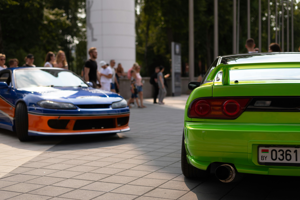

In [37]:
from PIL import Image

Image.open('100_CNN_StyleTransfer/imagen contenido.jpg')
size = (300, 200)

image = image.resize(size)

image.show()

- Style Image

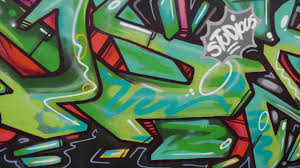

In [35]:
Image.open('100_CNN_StyleTransfer/imagen de estilo.jpg')

In [6]:
preprocess_steps = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])
content_img = Image.open('/workspaces/Deep_Learning/100_CNN_StyleTransfer/imagen contenido.jpg').convert('RGB')
content_img = preprocess_steps(content_img)

# a new dimension is added to a tensor, and the shape of the resulting tensor is printed
# [batch_size, channels, height, width] Pytorch structure
content_img = torch.unsqueeze(content_img, 0)
print(content_img.shape)

style_img = Image.open('/workspaces/Deep_Learning/100_CNN_StyleTransfer/imagen de estilo.jpg').convert('RGB')
style_img = preprocess_steps(style_img)

# [batch_size, channels, height, width] Pytorch structure
style_img = torch.unsqueeze(style_img, 0)
print(style_img.shape)

torch.Size([1, 3, 300, 300])
torch.Size([1, 3, 300, 300])


### FEATURE EXTRACTION

*The LOSS_LAYERS dictionary maps the layer indices of the VGG19 model to more descriptive layer names. These layers are specific because they will be used to calculate content and style losses in a style transfer algorithm*

In [7]:
LOSS_LAYERS = { '0': 'conv1_1', 
                '5': 'conv2_1',  
                '10': 'conv3_1', 
                '19': 'conv4_1', 
                '21': 'conv4_2', 
                '28': 'conv5_1'}

# traverses the model layer by layer, applying each layer to the input tensor and saving the outputs of the specified layers to the dictionary
def extract_features(x, model):
    features = {}   
    for name, layer in model._modules.items(): # the function traverses through the layers of the model and returns an iterator over the layers of the model
        x = layer(x) # for each layer, the current layer is applied to the input tensor x, updating x with the layer's output
        
        # if the current layer name is in the LOSS_LAYERS dictionary, the output of the layer is stored in the features dictionary with the corresponding descriptive name
        if name in LOSS_LAYERS:
            features[LOSS_LAYERS[name]] = x   
            
    return features

# extract characteristics of content and style images
content_img_features = extract_features(content_img, vgg)
style_img_features = extract_features(style_img, vgg)

*The feature Gram matrix is calculated. Then, this function is applied to the features extracted from the multi-layered style image to obtain the feature Gram matrices for each layer*

In [8]:
def calc_gram_matrix(tensor):
    _, C, H, W = tensor.size() # _ is used to discard the lot size
    tensor = tensor.view(C, H * W)    
    gram_matrix = torch.mm(tensor, tensor.t()) # multiplies the tensor by its transpose
    gram_matrix = gram_matrix.div(C * H * W)  # the Gram matrix is divided by the number of elements in the layer to normalise it
    return gram_matrix

# calc_gram_matrix is applied to the features extracted from the style image on each layer
style_features_gram_matrix = {layer: calc_gram_matrix(style_img_features[layer]) for layer in 
                                                    style_img_features}


### OPTIMISATION

*Optimisation of the target image to minimise the total loss, which usually consists of a loss of content and a loss of style*

*A weight is assigned to each style layer. These weights determine how much each layer contributes to the total style loss. Generally, deeper layers have less weight, as they are considered to capture more abstract aspects of the style*

*The target image is initialised by cloning the content image and marking it as requiring gradients. This allows gradients to propagate through the target image during optimisation*

*An Adam optimiser is initialised to optimise the pixels of the target image. The lr parameter specifies the learning rate, which controls the magnitude of the adjustments made at each optimisation step*

In [9]:
weights = {'conv1_1': 1.0, 'conv2_1': 0.8, 'conv3_1': 0.6,
           'conv4_1': 0.4, 'conv5_1': 0.2}

target = content_img.clone().requires_grad_(True)

optimizer = Adam([target], lr=0.003)

### TRAIN AND RESULTS

*Iterates over 100 epochs to optimise the target image with respect to the total loss, which consists of a loss of style and a loss of content*

In [10]:
for i in range(1, 100):
    
    target_features = extract_features(target, vgg)

    # the content loss between the ‘conv4_2’ layer of the target image features and the content image is calculated
    content_loss = mse_loss (target_features['conv4_2'], content_img_features['conv4_2'])
    
    # the style loss is calculated for each style layer
    style_loss = 0
    for layer in weights:
  
        target_feature = target_features[layer]

        # the style loss in each layer is calculated by comparing the Gram matrix of the target image with the Gram matrix of the corresponding style image
        target_gram_matrix = calc_gram_matrix(target_feature)
        style_gram_matrix = style_features_gram_matrix[layer]
        
        # each layer loss is multiplied by the corresponding weight defined in weights and summed to obtain the total style loss
        layer_loss = mse_loss (target_gram_matrix, style_gram_matrix) * weights[layer]
        style_loss += layer_loss  
    
    # the loss of style is multiplied by a factor of 1,000,000 to adjust its scale
    total_loss = 1000000 * style_loss + content_loss
    
    if i % 10 == 0:
        print (f"Epoch {i}:, Style Loss : {style_loss}, Content Loss : {content_loss}")
    
    # the backpropagation process is performed to calculate the gradients of the total loss with respect to the pixels of the target image
    # the pixels of the target image are updated using the optimiser to minimise the total loss.
    optimizer.zero_grad()
    total_loss.backward(retain_graph=True)
    optimizer.step()

Epoch 10:, Style Loss : 5.368831352825509e-06, Content Loss : 0.8001059889793396
Epoch 20:, Style Loss : 3.067877969442634e-06, Content Loss : 1.0585527420043945
Epoch 30:, Style Loss : 2.12502573049278e-06, Content Loss : 1.0914884805679321
Epoch 40:, Style Loss : 1.70564987911348e-06, Content Loss : 1.0516520738601685
Epoch 50:, Style Loss : 1.476339207329147e-06, Content Loss : 1.0094937086105347
Epoch 60:, Style Loss : 1.3314891020854702e-06, Content Loss : 0.9738885164260864
Epoch 70:, Style Loss : 1.2317723303567618e-06, Content Loss : 0.9447724223136902
Epoch 80:, Style Loss : 1.1569534308364382e-06, Content Loss : 0.9224335551261902
Epoch 90:, Style Loss : 1.096640858122555e-06, Content Loss : 0.9062782526016235


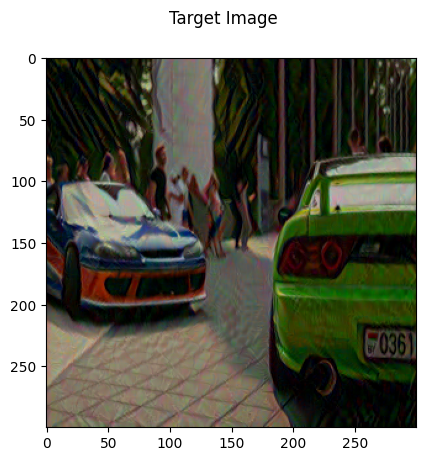

In [11]:
# normalise the images before they are processed by the neural network
# when the image is displayed, this normalisation is reversed to restore the original appearance
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

def tensor_to_image(tensor):

    # cloning and tensor Separation
    image = tensor.clone().detach()
    image = image.cpu().numpy().squeeze()
    
    # the tensor is transposed to match the expected format of matplotlib
    image = image.transpose(1, 2, 0)

    # denormalisation
    image *= np.array(std) + np.array(mean)

    # the pixel values are trimmed to ensure that they are within the valid range [0, 1]
    image = image.clip(0, 1)

    return image

import matplotlib.pyplot as plt
img = tensor_to_image(target)
fig = plt.figure()
fig.suptitle('Target Image')
plt.imshow(img)

-----------